### **Modified Black Jack: A Cards Game**

#### Objective: <br>

To train an agent to play a simplified Blackjack game especially using Monte Carlo and Sarsa(λ) reinforcement learning methods, and then compare their performance in learning the optimal strategy.

## Team Members

Amit Magar: 200567979 <br>

Sravya Neha Medaramitla: 200612749  <br>

Darshit Manojkumar Limbachiya: 200611012 

### Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

### Define BlackjackGame Environment

In [2]:
class BlackjackGame:
    def __init__(self):
        self.player_total = 0
        self.dealer_upcard = 0
        self.done = False

    def new_game(self):
        """Resets the game and returns the starting values for the player and dealer."""
        self.player_total = np.random.randint(1, 22)  # Random starting total for player
        self.dealer_upcard = np.random.randint(1, 14)  # Random dealer's visible card
        self.done = False  # Game is not over yet
        return (self.player_total, self.dealer_upcard)

    def play_step(self, action):
        """
        Takes an action in the game.
        Action 1: Hit, Action 0: Stick.
        Returns:
            next_state: (player_total, dealer_upcard)
            reward: result of the action (1: win, -1: lose, 0: draw)
            finished: whether the game is over
        """
        if action == 1:  # If the action is 'Hit'
            card = np.random.randint(1, 14)  # Draw a random card
            card_color = np.random.rand()  # Randomly decide if the card is red or black
            
            if card_color < 1/3:  # If the card is red
                self.player_total -= card  # Subtract the card value from player's total
            else:
                self.player_total += card  # Add the card value to player's total
            
            if self.player_total > 21 or self.player_total < 1:  # Player busts
                self.done = True  # End the game
                return (self.player_total, self.dealer_upcard), -1, True  # Player loses
        
        else: 
            self.done = True
            dealer_total = self.dealer_upcard
            while dealer_total < 17:  # Dealer keeps drawing until total is 17 or more
                card = np.random.randint(1, 14)  # Dealer draws a card
                if np.random.rand() < 1/3:  # Random chance of red or black card
                    dealer_total -= card  # Red card makes dealer's total go down
                else:
                    dealer_total += card  # Black card adds to dealer's total
            
            if dealer_total > 21 or dealer_total < 1:  # Dealer busts
                return (self.player_total, self.dealer_upcard), 1, True  # Player wins
            elif dealer_total > self.player_total:  # Dealer wins
                return (self.player_total, self.dealer_upcard), -1, True  # Player loses
            elif dealer_total == self.player_total:  # Draw
                return (self.player_total, self.dealer_upcard), 0, True  # It's a draw
            else:  
                return (self.player_total, self.dealer_upcard), 1, True  # Player wins
        
        return (self.player_total, self.dealer_upcard), 0, False  # Game continues

### Initialization and Execution

In [5]:
# Initialize the game environment
game_env = BlackjackGame()

### Monte Carlo Control Implementation

In [6]:
def mc_control(game, num_episodes=100000, discount=1.0, eps_base=100):
    Q_values = defaultdict(lambda: {0: 0, 1: 0})  # Store Q-values for each state-action pair
    visit_count = defaultdict(lambda: {0: 0, 1: 0})  # Track the number of visits for each state-action pair
    
    for _ in range(num_episodes):
        state = game.new_game()  # Start a new game and get initial state
        episode_log = []  # Keep track of the episode steps
        seen = set() 
        
        # Generating an episode
        while True:
            epsilon = eps_base / (eps_base + sum(visit_count[state].values()))  # Calculate epsilon for exploration vs exploitation
            if np.random.rand() < epsilon:  
                chosen_action = np.random.choice([0, 1])  
            else:
                chosen_action = max(Q_values[state], key=Q_values[state].get)  # Choose the action with the highest Q-value
            
            next_state, reward, finished = game.play_step(chosen_action)  # Play the action and get the next state and reward
            episode_log.append((state, chosen_action, reward))  # 
            state = next_state  
            if finished: 
                break
        
        total_return = 0  
        for s, a, r in reversed(episode_log):  
            total_return = discount * total_return + r  
            if (s, a) not in seen:  # Only update the Q-value if this state-action pair hasn't been updated yet
                seen.add((s, a))  
                visit_count[s][a] += 1  
                step_size = 1 / visit_count[s][a]  
                Q_values[s][a] += step_size * (total_return - Q_values[s][a])  
    
    return Q_values 

In [7]:
# Run Monte Carlo Control to obtain baseline Q-values
mc_Q = mc_control(game_env)

### Plotting the graph

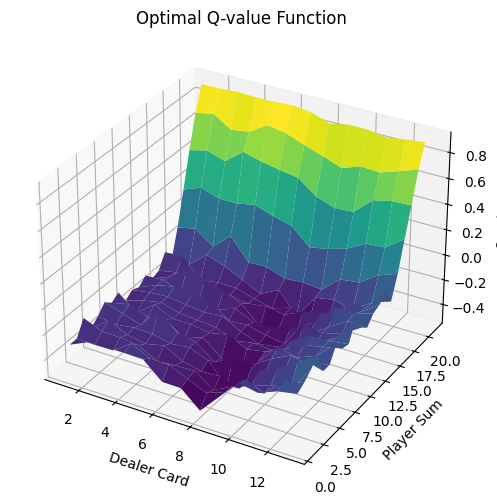

In [8]:
def plot_q_surface(Q):
    player_range = np.arange(1, 22)  # Range of possible player sums (1 to 21)
    dealer_range = np.arange(1, 14)  # Range of possible dealer card values (1 to 13)
    X, Y = np.meshgrid(dealer_range, player_range)  # Create a grid for the dealer's card and player's sum
    Z = np.array([[max(Q.get((p, d), {0:0, 1:0}).values()) for d in dealer_range] for p in player_range])  # Get the optimal Q-values for each state
    
    fig = plt.figure(figsize=(8, 6))  
    ax = fig.add_subplot(111, projection='3d')  
    surf = ax.plot_surface(X, Y, Z, cmap='viridis') 
    ax.set_xlabel('Dealer Card')  
    ax.set_ylabel('Player Sum')  
    ax.set_zlabel('Q-value') 
    ax.set_title('Optimal Q-value Function') 
    plt.show()  

# Plot the Monte Carlo optimal Q-value surface
plot_q_surface(mc_Q)

### SARSA(λ) Implementation

In [9]:
def forward_sarsa(game, num_episodes=100000, discount=1.0, step_size=0.01, eps_base=100, lam_values=np.linspace(0, 1, 11)):
    mse_per_lambda = []  
    Q_collection = {lam: defaultdict(lambda: {0: 0, 1: 0}) for lam in lam_values}  
    for lam in lam_values:  
        Q = defaultdict(lambda: {0: 0, 1: 0})  # Initialize Q-values for this lambda
        
        for _ in range(num_episodes):  
            state = game.new_game()  # Start a new game and get the initial state
            epsilon = eps_base / (eps_base + sum(Q[state].values()))  # Calculate epsilon for exploration vs exploitation
            action = np.random.choice([0, 1]) if np.random.rand() < epsilon else max(Q[state], key=Q[state].get)  
            episode_trace = []  # List to store the steps of the episode
            
            while True:  
                next_state, reward, finished = game.play_step(action) 
                episode_trace.append((state, action, reward))  
                
                if finished:  
                    break
                
                state = next_state  
                epsilon = eps_base / (eps_base + sum(Q[state].values()))  # Recalculate epsilon
                action = np.random.choice([0, 1]) if np.random.rand() < epsilon else max(Q[state], key=Q[state].get)  
            
            # For each time step in the episode, calculate the forward view return and update Q-values.
            T = len(episode_trace)  # Get the length of the episode
            for t in range(T):  
                G_return = sum([discount**(k - t) * episode_trace[k][2] for k in range(t, T)])  
                s, a, _ = episode_trace[t]  # Get the state and action for this time step
                Q[s][a] += step_size * (G_return - Q[s][a])  

        # Calculate the Mean Squared Error (MSE) between the new Q-values and the previous Q-values for this lambda
        mse_val = np.mean([(Q[s][a] - Q_collection[lam][s][a])**2 for s in Q for a in [0, 1]])  # Calculate MSE
        mse_per_lambda.append(mse_val)  # Store the MSE for this lambda
        Q_collection[lam] = Q  # Store the updated Q-values for this lambda

    return mse_per_lambda, Q_collection  

In [10]:
# Run Forward SARSA(λ) over a range of lambda values
lambda_vals = np.linspace(0, 1, 11)
mse_vals, sarsa_Q_collection = forward_sarsa(game_env, lam_values=lambda_vals)

### Plotting the graph

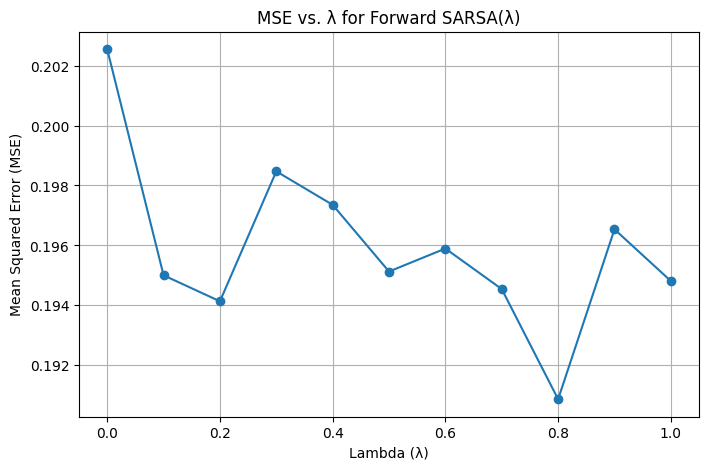

In [11]:

def plot_mse(lambdas, mse_values):
    plt.figure(figsize=(8, 5))  
    plt.plot(lambdas, mse_values, marker='o')  
    plt.xlabel("Lambda (λ)")  
    plt.ylabel("Mean Squared Error (MSE)")  
    plt.title("MSE vs. λ for Forward SARSA(λ)")  
    plt.grid(True)  
    plt.show()  

# Plot Mean Squared Error vs. Lambda for Forward SARSA(λ)
plot_mse(lambda_vals, mse_vals)

### The learning curve of MSE against episode number

In [12]:
def sarsa_learning_curve(game, num_episodes=100000, discount=1.0, step_size=0.01, eps_base=100, lam_values=[0, 1]):
    mse_per_episode_lambda = {lam: [] for lam in lam_values} 
    Q_collection_lambda = {lam: defaultdict(lambda: {0: 0, 1: 0}) for lam in lam_values} 

    for lam in lam_values:  
        Q = defaultdict(lambda: {0: 0, 1: 0})  # Initialize Q-values for this lambda
        mse_per_episode = []  
        
        for episode_num in range(num_episodes):  
            state = game.new_game() 
            epsilon = eps_base / (eps_base + sum(Q[state].values()))  # Calculate epsilon for exploration vs exploitation
            action = np.random.choice([0, 1]) if np.random.rand() < epsilon else max(Q[state], key=Q[state].get)  
            episode_log = []  

            while True:  
                next_state, reward, finished = game.play_step(action)  
                episode_log.append((state, action, reward))  
                
                if finished:  
                    break
                
                state = next_state  
                epsilon = eps_base / (eps_base + sum(Q[state].values()))  # Recalculate epsilon
                action = np.random.choice([0, 1]) if np.random.rand() < epsilon else max(Q[state], key=Q[state].get)  
            
            # Update Q-values for each state-action pair based on the actual reward at each step
            for s, a, r in episode_log:
                Q[s][a] += step_size * (r - Q[s][a])  # Update the Q-value using the step size and reward
            
            # Calculate Mean Squared Error (MSE) for the current Q-values
            mse_val = np.mean([(Q[s][a] - Q_collection_lambda[lam][s][a])**2 for s in Q for a in [0, 1]])  # Compute MSE
            mse_per_episode.append(mse_val)  # Store the MSE for this episode
        
        mse_per_episode_lambda[lam] = mse_per_episode  # Store MSE values for this lambda
        Q_collection_lambda[lam] = Q  # Store the Q-values for this lambda

    return mse_per_episode_lambda, Q_collection_lambda  # Return the MSE values and Q-values for each lambda

In [13]:
def plot_learning_curve_lambda_vs_episode(mse_per_episode_lambda, num_episodes):
    plt.figure(figsize=(8, 5))  
    
    for lam, mse_values in mse_per_episode_lambda.items():  
        plt.plot(range(num_episodes), mse_values, label=f'λ = {lam}')  
    
    plt.xlabel("Episode Number")  
    plt.ylabel("Mean Squared Error (MSE)")  
    plt.title("Learning Curve: MSE vs. Episode Number")  
    plt.legend()  
    plt.grid(True)  
    plt.show()  

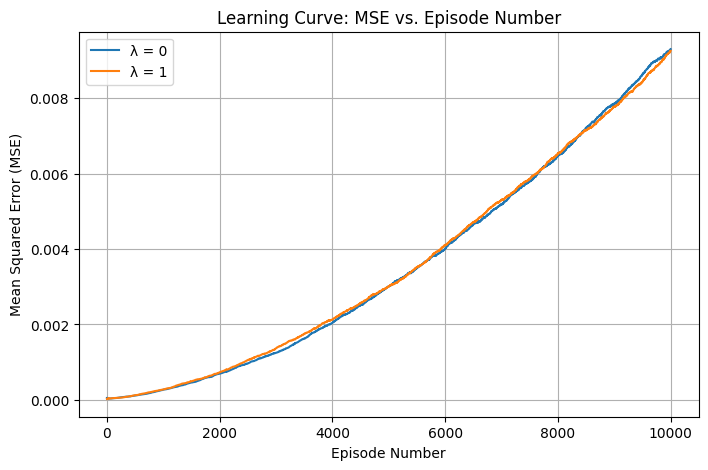

In [14]:
# Run SARSA without eligibility traces for λ = 0 and λ = 1
num_episodes = 10000
mse_per_episode_lambda, _ = sarsa_learning_curve(game_env, num_episodes=num_episodes)

# Plot the learning curve
plot_learning_curve_lambda_vs_episode(mse_per_episode_lambda, num_episodes)